In [34]:
from __future__ import division, print_function, unicode_literals
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
import pandas as pd
from scipy.stats import pearsonr,spearmanr
from joblib import dump, load
import os
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

#### Caps Net Architecture

In [103]:
tf.reset_default_graph()
np.random.seed(42)
tf.set_random_seed(42)
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")


X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}
conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)
conv2 = tf.layers.conv2d(conv1, name="conv2", **conv2_params)
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")

def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

caps1_output = squash(caps1_raw, name="caps1_output")
caps2_n_caps = 10
caps2_n_dims = 16
init_sigma = 0.1

W_init = tf.random_normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

batch_size = tf.shape(X)[0]

W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled")
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")

routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")

weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True,
                             name="weighted_sum")
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")

caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_1_tiled")

agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")
raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="raw_weights_round_2")
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        dim=2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keep_dims=True,
                                     name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")
caps2_output = caps2_output_round_2

def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")

y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")

y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


#### Margin Loss and Reconstruction Loss

In [104]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5
T = tf.one_hot(y, depth=caps2_n_caps, name="T")
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                           name="present_error")
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                          name="absent_error")
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")
reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="reconstruction_mask")
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
    name="reconstruction_mask_reshaped")
caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")
decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="decoder_input")
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28
with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                              name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output,
                                     activation=tf.nn.sigmoid,
                                     name="decoder_output")
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference,
                                    name="reconstruction_loss")

alpha = 0.0005

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Caps Net Training

In [105]:
n_epochs = 0
batch_size = 50
restore_checkpoint = True

n_iterations_per_epoch = mnist.train.num_examples // batch_size
n_iterations_validation = mnist.validation.num_examples // batch_size
best_loss_val = np.infty
checkpoint_path = "./my_capsule_network"

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val
            
            

INFO:tensorflow:Restoring parameters from ./my_capsule_network


### Caps Net Evaluation

In [106]:
n_iterations_test = mnist.test.num_examples // batch_size

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = mnist.test.next_batch(batch_size)
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))
    

INFO:tensorflow:Restoring parameters from ./my_capsule_network
Final test accuracy: 99.3600%  Loss: 0.007339   


#### Storing training and testing sets

In [107]:
# n_iterations_train = mnist.train.num_examples // batch_size
# y_train = np.array([])
# x_train = []

# for iteration in range(1, n_iterations_train + 1):
#     X_batch, y_batch = mnist.train.next_batch(batch_size,shuffle=False)
#     y_train = np.append(y_train,y_batch)
#     if x_train == []:
#         x_train = X_batch
#     else:
#         x_train = np.vstack((x_train,X_batch))
        
# print(x_train.shape,y_train.shape)
# print(y_train[0],y_train[1],y_train[-1],y_train[-2])
# with open('x_train.pickle', 'wb') as handle:
#     pickle.dump(x_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('y_train.pickle', 'wb') as handle:
#     pickle.dump(y_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

# n_iterations_test = mnist.test.num_examples // batch_size

# y_test = np.array([])
# x_test = []
# for iteration in range(1, n_iterations_test + 1):
#     X_batch, y_batch = mnist.test.next_batch(batch_size,shuffle=False)
#     y_test = np.append(y_test,y_batch)
#     if x_test == []:
#         x_test = X_batch
#     else:
#         x_test = np.vstack((x_test,X_batch))

# print(x_test.shape,y_test.shape)

# with open('x_test.pickle', 'wb') as handle:
#     pickle.dump(x_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('y_test.pickle', 'wb') as handle:
#     pickle.dump(y_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Calculating Probabilities i.e. Confidence of Caps Net on Test Set

In [134]:
with open('x_test.pickle', 'rb') as handle:
    x_test = pickle.load(handle)
with open('y_test.pickle', 'rb') as handle:
    y_test = pickle.load(handle)

def my_safe_norm(s, axis=-1, epsilon=1e-7, keepdims=False):
    squared_norm = np.sum(np.square(s), axis=axis,
                                     keepdims=keepdims)
    return np.sqrt(squared_norm + epsilon).squeeze()

def get_probs(a):
    return np.max(a.squeeze(), axis=1)


n_iterations_test = mnist.test.num_examples // batch_size

caps_probs = np.array([])
caps_preds = np.array([])
caps_final_activations = np.empty(shape=(10000,10,16))
with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    for iteration in range(1, n_iterations_test + 1):
        start=(iteration-1)*batch_size
        end= start + batch_size
        X_batch = x_test[start:end]
        y_batch = y_test[start:end]
        caps2_output_value, decoder_output_value, y_pred_value = sess.run(
                [caps2_output, decoder_output, y_pred],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
        caps_final_activations[start:end,]=np.squeeze(caps2_output_value)
        caps_probs = np.append(caps_probs,get_probs(my_safe_norm(caps2_output_value,axis=-2)))
        caps_preds = np.append(caps_preds,y_pred_value)
    print("\rFinal values less than 0.8 prob: {:.4f}".format(np.sum(caps_preds < 0.8)))    

INFO:tensorflow:Restoring parameters from ./my_capsule_network
Final values less than 0.8 prob: 981.0000       


In [10]:
# n=mnist.test.num_examples
# m=mnist.train.num_examples
# print(m+n+mnist.validation.num_examples)
# labels = mnist.test.labels
# correct = np.sum(labels==y_correct)
# print(labels)
# print(y_correct)
# print(correct)
# correct=64
# (n-correct)/n

### Plotting Caps Net Predictions

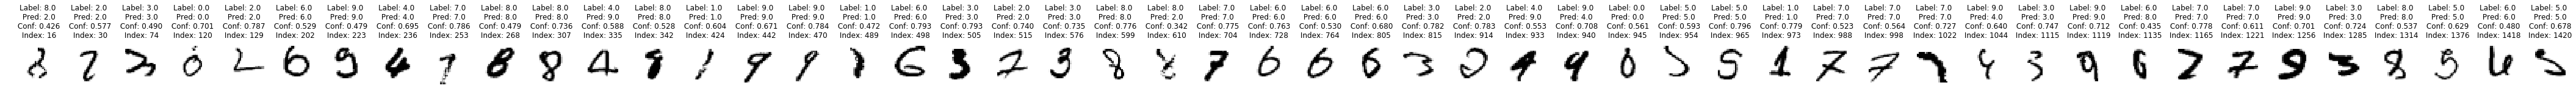

In [11]:
caps_reqd_indices = [i for i in range(len(caps_probs)) if caps_probs[i] < 0.8]
no = len(caps_reqd_indices[:50])
plt.figure(figsize=(no*1.5, 5))
for index in range(no):
    plt.subplot(1, no, index + 1)
    ind = caps_reqd_indices[index]
    plt.imshow(x_test.reshape([-1, 28, 28])[ind], cmap="binary")
    plt.title("Label: {0}\n Pred: {1}\n Conf: {2:.3f}\n Index: {3}".format(y_test[ind],caps_preds[ind],caps_probs[ind],ind))
    plt.axis("off")

plt.show()

#### Conv Net Training and Evaluation

In [83]:
# Training Parameters
learning_rate = 0.001
num_steps = 10000
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit


# Create the neural network
def conv_net(x_dict, n_classes,1 dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out


# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False,
                            is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True,
                           is_training=False)

    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    predictions = {
      "pred_classes": pred_classes,
      "probabilities": pred_probas,
        "raw_scores": logits_test
    }
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

        # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op,
                                  global_step=tf.train.get_global_step())

    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op})

    return estim_specs

# Build the Estimator
model = tf.estimator.Estimator(model_fn)

# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
e = model.evaluate(input_fn)

print("Testing Accuracy:", e['accuracy'])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/8s/b5bvrrgx7hsg1m26nkw_m5s00000gn/T/tmpfcwx545p', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x133a6cac8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Chec

INFO:tensorflow:global_step/sec: 21.6072
INFO:tensorflow:loss = 0.030749457, step = 6801 (4.628 sec)
INFO:tensorflow:global_step/sec: 21.5877
INFO:tensorflow:loss = 0.0014505709, step = 6901 (4.632 sec)
INFO:tensorflow:global_step/sec: 21.0273
INFO:tensorflow:loss = 0.00018223755, step = 7001 (4.756 sec)
INFO:tensorflow:global_step/sec: 21.3733
INFO:tensorflow:loss = 0.00019482842, step = 7101 (4.679 sec)
INFO:tensorflow:global_step/sec: 21.5426
INFO:tensorflow:loss = 1.1446568e-05, step = 7201 (4.642 sec)
INFO:tensorflow:global_step/sec: 17.8273
INFO:tensorflow:loss = 0.017808395, step = 7301 (5.609 sec)
INFO:tensorflow:global_step/sec: 18.8924
INFO:tensorflow:loss = 0.008108745, step = 7401 (5.293 sec)
INFO:tensorflow:global_step/sec: 20.9033
INFO:tensorflow:loss = 0.0053744833, step = 7501 (4.784 sec)
INFO:tensorflow:global_step/sec: 18.2998
INFO:tensorflow:loss = 0.014436968, step = 7601 (5.465 sec)
INFO:tensorflow:global_step/sec: 20.4656
INFO:tensorflow:loss = 0.006816936, step =

#### Conv Net Confidence Estimation

In [82]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': x_test}, y=y_test,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
e = list(model.predict(input_fn,predict_keys="probabilities"))
preds = np.array([i['probabilities'] for i in e])
f = list(model.predict(input_fn,predict_keys="raw_scores"))
raw_scores = np.array([i['raw_scores'] for i in f])
conv_probs = np.max(preds,axis=1)
conv_preds = np.argmax(preds,axis=1)
conv_scores = np.max(raw_scores,axis=1)
print("\rFinal values less than 0.8 prob: {:.4f}".format(np.sum(conv_probs < 0.8)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/8s/b5bvrrgx7hsg1m26nkw_m5s00000gn/T/tmpk12pqvtw/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/8s/b5bvrrgx7hsg1m26nkw_m5s00000gn/T/tmpk12pqvtw/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Final values less than 0.8 prob: 48.0000


### Plotting Conv Net Predictions

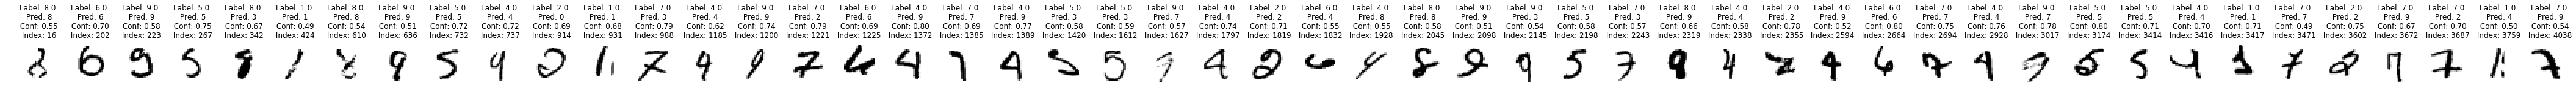

In [21]:
conv_reqd_indices = [i for i in range(len(conv_probs)) if conv_probs[i] < 0.8]
no = len(conv_reqd_indices[:50])
plt.figure(figsize=(no*1.5, 5))
for index in range(no):
    plt.subplot(1, no, index + 1)
    ind = conv_reqd_indices[index]
    plt.imshow(x_test.reshape([-1, 28, 28])[ind], cmap="binary")
    plt.title("Label: {0}\n Pred: {1}\n Conf: {2:.2f}\n Index: {3}".format(y_test[ind],conv_preds[ind],conv_probs[ind],ind))
    plt.axis("off")

plt.show()

### SVM Training

In [37]:
with open('x_train.pickle', 'rb') as handle:
    x_train = pickle.load(handle)
with open('y_train.pickle', 'rb') as handle:
    y_train = pickle.load(handle)

# scaler = StandardScaler()
# x_train_scaled = scaler.fit_transform(x_train.astype(np.float32))
 
# with open('x_train_scaled.pickle', 'wb') as handle:
#     pickle.dump(x_train_scaled, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('x_train_scaled.pickle', 'rb') as handle:
    x_train_scaled = pickle.load(handle)

if os.path.isfile('svm_model.joblib'):
    svm_model = load('svm_model.joblib') 
else:
    svm_clf = SVC(decision_function_shape="ovr", gamma="auto")
    # svm_clf.fit(x_train_scaled[:10000], y_train[:10000])
    # print('Training Acc')
    # y_pred = svm_clf.predict(x_train_scaled)
    # accuracy_score(y_train, y_pred)
    param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
    rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
    rnd_search_cv.fit(x_train_scaled[:1000], y_train[:1000])
    print(rnd_search_cv.best_score_)
    print(rnd_search_cv.best_estimator_)
    svm_model = rnd_search_cv.best_estimator_.fit(x_train_scaled, y_train)
    dump(svm_model,'svm_model.joblib')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=9.804678390152578, gamma=0.017729973899342284 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. C=9.804678390152578, gamma=0.017729973899342284, total=   0.8s
[CV] C=9.804678390152578, gamma=0.017729973899342284 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] .. C=9.804678390152578, gamma=0.017729973899342284, total=   0.8s
[CV] C=9.804678390152578, gamma=0.017729973899342284 .................
[CV] .. C=9.804678390152578, gamma=0.017729973899342284, total=   0.8s
[CV] C=3.95633685837714, gamma=0.001625505785817306 ..................
[CV] ... C=3.95633685837714, gamma=0.001625505785817306, total=   0.6s
[CV] C=3.95633685837714, gamma=0.001625505785817306 ..................
[CV] ... C=3.95633685837714, gamma=0.001625505785817306, total=   0.6s
[CV] C=3.95633685837714, gamma=0.001625505785817306 ..................
[CV] ... C=3.95633685837714, gamma=0.001625505785817306, total=   0.6s
[CV] C=5.565345704829102, gamma=0.0027345185538655043 ................
[CV] . C=5.565345704829102, gamma=0.0027345185538655043, total=   0.7s
[CV] C=5.565345704829102, gamma=0.0027345185538655043 ................
[CV] . C=5.565345704829102, gamma=0.0027345185538655043, total=   0.7s
[CV] C=5.565345704829102, gamma=0.0027345185538655043 ................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   31.9s finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.858
SVC(C=3.95633685837714, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001625505785817306,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


#### SVM Evaluation

In [39]:
# x_test_scaled = scaler.transform(x_test.astype(np.float32))
# with open('x_test_scaled.pickle', 'wb') as handle:
#     pickle.dump(x_test_scaled, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('x_test_scaled.pickle', 'rb') as handle:
    x_test_scaled = pickle.load(handle)
    
print('Testing Acc')
svm_preds = svm_model.predict(x_test_scaled)
accuracy_score(y_test, svm_preds)

Testing Acc


0.9715

#### SVM confidence estimation

In [40]:
confidences = svm_model.decision_function(x_test_scaled)

In [41]:
svm_conf = np.max(confidences,axis=1)
svm_threshold = np.quantile(svm_conf,0.2)
print("\rTaking {:.4f} least confident examples at threshold {:.4f}. Min->{:.4f} Max->{:.4f}".
      format(np.sum(svm_conf < svm_threshold),svm_threshold,np.min(svm_conf),np.max(svm_conf)))

Taking 2000.0000 least confident examples at threshold 9.2249. Min->8.0499 Max->9.5000


### Plotting SVM Predictions

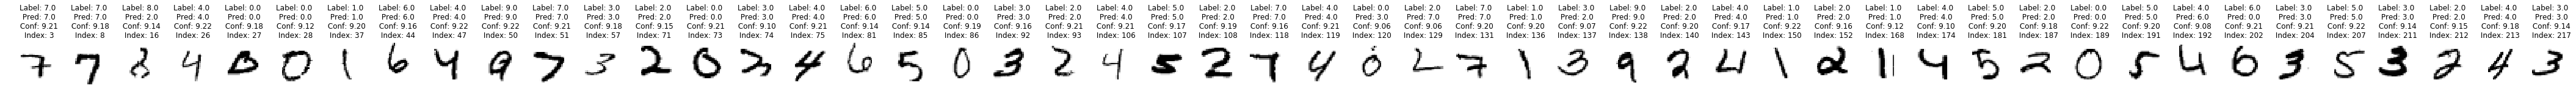

In [42]:
svm_reqd_indices = [i for i in range(len(svm_conf)) if svm_conf[i] < svm_threshold]
no = len(svm_reqd_indices[:50])
plt.figure(figsize=(no*1.5, 5))
for index in range(no):
    plt.subplot(1, no, index + 1)
    ind = svm_reqd_indices[index]
    plt.imshow(x_test.reshape([-1, 28, 28])[ind], cmap="binary")
    plt.title("Label: {0}\n Pred: {1}\n Conf: {2:.2f}\n Index: {3}".format(y_test[ind],svm_preds[ind],svm_conf[ind],ind))
    plt.axis("off")

plt.show()

## SVM Probability Model

In [44]:
with open('x_train.pickle', 'rb') as handle:
    x_train = pickle.load(handle)
with open('y_train.pickle', 'rb') as handle:
    y_train = pickle.load(handle)
    
with open('x_train_scaled.pickle', 'rb') as handle:
    x_train_scaled = pickle.load(handle)

if os.path.isfile('svm_prob_model.joblib'):
    svm_prob_model = load('svm_prob_model.joblib') 
else:
    svm_clf_pr = SVC(decision_function_shape="ovr", gamma="auto", probability=True)

    rnd_search_cv_pr = RandomizedSearchCV(svm_clf_pr, param_distributions, n_iter=10, verbose=2, cv=3)
    rnd_search_cv_pr.fit(x_train_scaled[:1000], y_train[:1000])
    print(rnd_search_cv_pr.best_score_)
    print(rnd_search_cv_pr.best_estimator_)
    svm_prob_model = rnd_search_cv_pr.best_estimator_.fit(x_train_scaled, y_train)
    dump(svm_prob_model, 'svm_prob_model.joblib')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=5.110370133182313, gamma=0.0011643980401875851 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . C=5.110370133182313, gamma=0.0011643980401875851, total=   2.0s
[CV] C=5.110370133182313, gamma=0.0011643980401875851 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] . C=5.110370133182313, gamma=0.0011643980401875851, total=   2.2s
[CV] C=5.110370133182313, gamma=0.0011643980401875851 ................
[CV] . C=5.110370133182313, gamma=0.0011643980401875851, total=   2.2s
[CV] C=4.45071248026683, gamma=0.01856533069072916 ...................
[CV] .... C=4.45071248026683, gamma=0.01856533069072916, total=   3.2s
[CV] C=4.45071248026683, gamma=0.01856533069072916 ...................
[CV] .... C=4.45071248026683, gamma=0.01856533069072916, total=   3.4s
[CV] C=4.45071248026683, gamma=0.01856533069072916 ...................
[CV] .... C=4.45071248026683, gamma=0.01856533069072916, total=   3.5s
[CV] C=7.807054515547668, gamma=0.011531058266441354 .................
[CV] .. C=7.807054515547668, gamma=0.011531058266441354, total=   3.2s
[CV] C=7.807054515547668, gamma=0.011531058266441354 .................
[CV] .. C=7.807054515547668, gamma=0.011531058266441354, total=   3.4s
[CV] C=7.807054515547668, gamma=0.011531058266441354 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.7min finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.864
SVC(C=5.110370133182313, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0011643980401875851,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [48]:
with open('x_test_scaled.pickle', 'rb') as handle:
    x_test_scaled = pickle.load(handle)
svm_prob_preds = svm_prob_model.predict(x_test_scaled)
svm_probs = np.max(svm_prob_model.predict_proba(x_test_scaled),axis=1)
print('Testing Acc')
accuracy_score(y_test, svm_prob_preds)

Testing Acc


0.9716

### Plotting SVM Prob Predictions

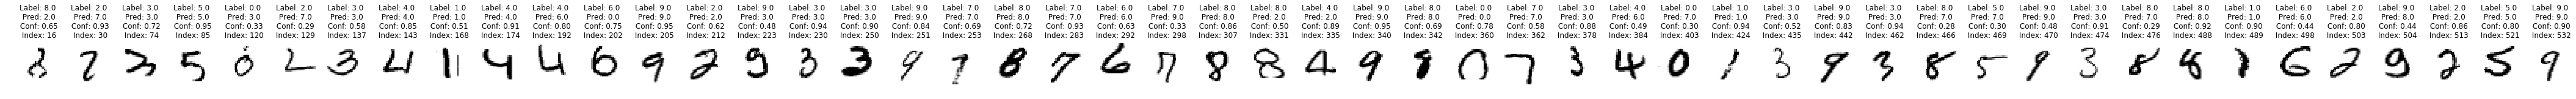

In [49]:
svm_prob_reqd_indices = [i for i in range(len(svm_probs)) if svm_probs[i] < 0.95]
no = len(svm_prob_reqd_indices[:50])
plt.figure(figsize=(no*1.5, 5))
for index in range(no):
    plt.subplot(1, no, index + 1)
    ind = svm_prob_reqd_indices[index]
    plt.imshow(x_test.reshape([-1, 28, 28])[ind], cmap="binary")
    plt.title("Label: {0}\n Pred: {1}\n Conf: {2:.2f}\n Index: {3}".format(y_test[ind],svm_prob_preds[ind],svm_probs[ind],ind))
    plt.axis("off")

plt.show()

### Plotting Common Predictions

### Bad Examples

43


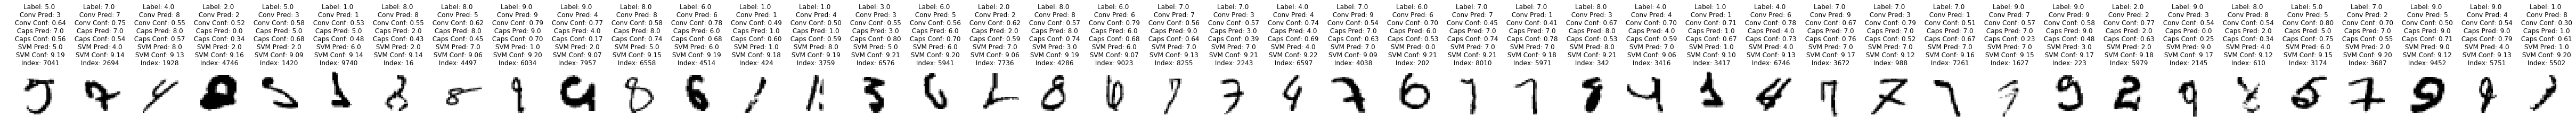

In [52]:
def Intersection(lst1, lst2): 
    return list(set(lst1).intersection(lst2))

all_common_bad = Intersection(Intersection(conv_reqd_indices,caps_reqd_indices),Intersection(svm_reqd_indices,svm_prob_reqd_indices))
print(len(all_common_bad))
no = len(all_common_bad)
plt.figure(figsize=(no*2, 10))
for index in range(no):
    plt.subplot(1, no, index + 1)
    ind = all_common_bad[index]
    plt.imshow(x_test.reshape([-1, 28, 28])[ind], cmap="binary")
    plt.title("Label: {0}\n Conv Pred: {1}\n Conv Conf: {2:.2f}\n Caps Pred: {3}\n Caps Conf: {4:.2f}\n SVM Pred: {5}\n SVM Conf: {6:.2f}\n Index: {7}".format(y_test[ind],conv_preds[ind],conv_probs[ind],caps_preds[ind],caps_probs[ind],svm_preds[ind],svm_conf[ind],ind))
    plt.axis("off")

plt.show()

### Good Examples

5346


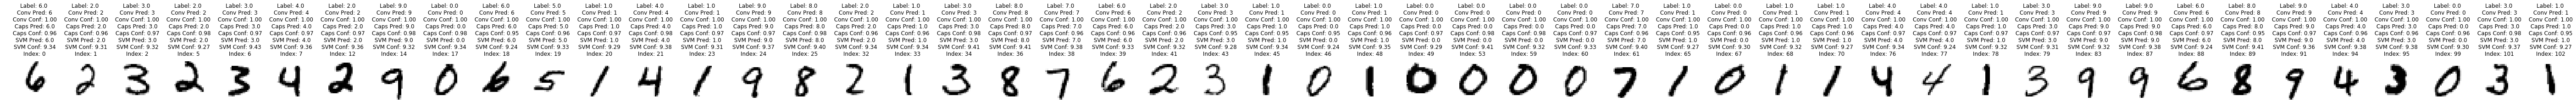

In [53]:
caps_reqd_indices2 = [i for i in range(len(caps_probs)) if caps_probs[i] > 0.95]
conv_reqd_indices2 = [i for i in range(len(conv_probs)) if conv_probs[i] > 0.95]
svm_threshold2 = np.quantile(svm_conf,0.99)
svm_reqd_indices2 = [i for i in range(len(svm_conf)) if svm_conf[i] > svm_threshold]
svm_prob_reqd_indices2 = [i for i in range(len(svm_probs)) if svm_probs[i] > 0.95]

all_common_good = Intersection(Intersection(conv_reqd_indices2,caps_reqd_indices2),Intersection(svm_reqd_indices2,svm_prob_reqd_indices2))
print(len(all_common_good))
no = len(all_common_good[:50])
plt.figure(figsize=(no*2, 10))
for index in range(no):
    plt.subplot(1, no, index + 1)
    ind = all_common_good[index]
    plt.imshow(x_test.reshape([-1, 28, 28])[ind], cmap="binary")
    plt.title("Label: {0}\n Conv Pred: {1}\n Conv Conf: {2:.2f}\n Caps Pred: {3}\n Caps Conf: {4:.2f}\n SVM Pred: {5}\n SVM Conf: {6:.2f}\n Index: {7}".format(y_test[ind],conv_preds[ind],conv_probs[ind],caps_preds[ind],caps_probs[ind],svm_preds[ind],svm_conf[ind],ind))
    plt.axis("off")

plt.show()

### Storing the indices

In [146]:
# with open('caps_reqd_indices2.pickle', 'wb') as handle:
#     pickle.dump(caps_reqd_indices2, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('svm_reqd_indices2.pickle', 'wb') as handle:
#     pickle.dump(svm_reqd_indices2, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('conv_reqd_indices2.pickle', 'wb') as handle:
#     pickle.dump(conv_reqd_indices2, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
# with open('caps_reqd_indices.pickle', 'wb') as handle:
#     pickle.dump(caps_reqd_indices, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('conv_reqd_indices.pickle', 'wb') as handle:
#     pickle.dump(conv_reqd_indices, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('svm_reqd_indices.pickle', 'wb') as handle:
#     pickle.dump(svm_reqd_indices, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Retrieving Indices

In [5]:
# with open('caps_reqd_indices2.pickle', 'rb') as handle:
#     caps_reqd_indices2=pickle.load(handle)
# with open('svm_reqd_indices2.pickle', 'rb') as handle:
#     svm_reqd_indices2=pickle.load(handle)
# with open('conv_reqd_indices2.pickle', 'rb') as handle:
#     conv_reqd_indices2=pickle.load(handle)

    
# with open('caps_reqd_indices.pickle', 'rb') as handle:
#     caps_reqd_indices=pickle.load(handle)
# with open('conv_reqd_indices.pickle', 'rb') as handle:
#     conv_reqd_indices=pickle.load(handle)
# with open('svm_reqd_indices.pickle', 'rb') as handle:
#     svm_reqd_indices=pickle.load(handle)

In [54]:
bad_indices_to_display = [4038,5389,4497,4981,8512,2523,2297,7213,3945,8528,1798,6944,6576,764,7968]
bad_indices_labels = [7,6,8,7,9,1,4,6,3,6,0,2,3,6,5]
good_indices_to_display = [1,2,0,8,7,20,17,19,25,50,88,75,49,47,18]
good_indices_labels = [2,3,6,7,4,1,0,5,8,9,6,4,0,4,6]

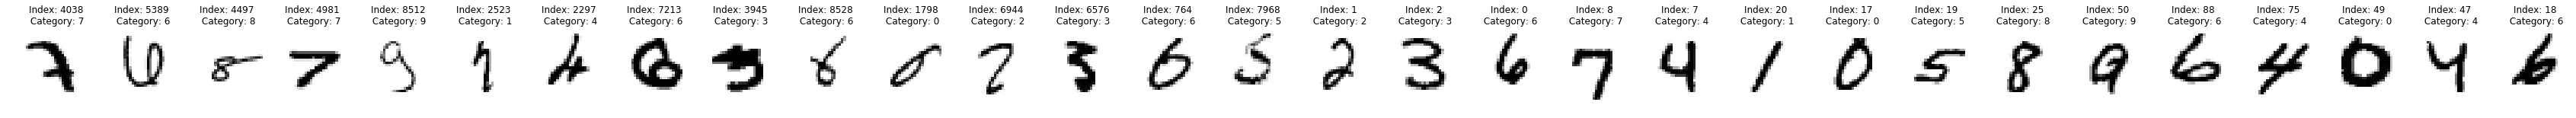

In [55]:
final = bad_indices_to_display+good_indices_to_display
final_ind = bad_indices_labels+good_indices_labels
no = len(final)
plt.figure(figsize=(no*2, 10))
for index in range(no):
    plt.subplot(1, no, index + 1)
    ind = final[index]
    label = final_ind[index]
    plt.imshow(x_test.reshape([-1, 28, 28])[ind], cmap="binary")
    plt.title("Index: {1}\n Category: {0}".format(label,ind))
    plt.axis("off")
plt.show()

### Generating random permutation for human testing

Total number of images: 30
Done


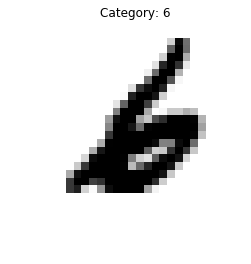

In [197]:
no = len(final)
print('Total number of images: {0}'.format(no))
temp = np.random.permutation(final)
set_1 = temp[:15]
set_2 = temp[15:]
# plt.figure(figsize=(no*2, 10))
for index in range(no):
#     plt.subplot(1, no, index + 1)
    ind = final[index]
    label = final_ind[index]
#     plt.imshow(x_test.reshape([-1, 28, 28])[ind], cmap="binary")
    plt.title("Category: {0}".format(label,ind))
    plt.axis("off")
    name = str(ind)
    if ind in bad_indices_to_display:
        name += '_bad-' 
    else:
        name += '_good-'
    name += str(label)
    if ind in set_1:
        plt.savefig('./set1/'+name)
    else:
        plt.savefig('./set2/'+name)
    
print('Done')
set_1 = np.sort(set_1)
set_2 = np.sort(set_2)

In [56]:
set_1 = [0,1,17,18,19,25,49,764,1798,2297,2523,3945,4038,5389,6576]
set_2 = [2,7,8,20,47,50,75,88,4497,4981,6944,7213,7968,8512,8528]
print(set_1)
print(set_2)
full_set = np.append(set_1,set_2)

[0, 1, 17, 18, 19, 25, 49, 764, 1798, 2297, 2523, 3945, 4038, 5389, 6576]
[2, 7, 8, 20, 47, 50, 75, 88, 4497, 4981, 6944, 7213, 7968, 8512, 8528]


In [57]:
with open('caps_probs.pickle', 'wb') as handle:
    pickle.dump(caps_probs, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('conv_probs.pickle', 'wb') as handle:
    pickle.dump(conv_probs, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('conv_scores.pickle', 'wb') as handle:
    pickle.dump(conv_probs, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('svm_conf.pickle', 'wb') as handle:
    pickle.dump(svm_conf, handle, protocol=pickle.HIGHEST_PROTOCOL)  
with open('svm_probs.pickle', 'wb') as handle:
    pickle.dump(svm_probs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [58]:
filenames = []
for index in range(len(full_set)):
    ind = full_set[index]
    label = final_ind[np.where(final==ind)[0][0]]
    name = str(ind)
    if ind in bad_indices_to_display:
        name += '_bad-' 
    else:
        name += '_good-'
    name += str(label)
    filenames.append(name)

In [59]:
# with open('sets.pickle', 'wb') as handle:
#     pickle.dump(temp, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
set1_responses = pd.read_csv('responses1.csv',skiprows=1,names=set_1)
set2_responses = pd.read_csv('responses2.csv',skiprows=1,names=set_1)

In [61]:
human_conf_set1 = set1_responses.mean().values
human_conf_set2 = set2_responses.mean().values
full_human_set = np.append(human_conf_set1,human_conf_set2)

In [62]:
for i in zip(filenames[:15],caps_probs[set_1],human_conf_set1):
    print(i)

('0_good-6', 0.9570136070251465, 7.611111111111111)
('1_good-2', 0.9598756432533264, 5.833333333333333)
('17_good-0', 0.9758022427558899, 6.805555555555555)
('18_good-6', 0.9545558094978333, 5.694444444444445)
('19_good-5', 0.9577595591545105, 7.527777777777778)
('25_good-8', 0.9789072275161743, 8.694444444444445)
('49_good-0', 0.9685713052749634, 6.416666666666667)
('764_bad-6', 0.5296176671981812, 5.916666666666667)
('1798_bad-0', 0.3505215346813202, 2.4444444444444446)
('2297_bad-4', 0.6820608377456665, 5.333333333333333)
('2523_bad-1', 0.6435756087303162, 2.5)
('3945_bad-3', 0.5326550602912903, 2.4166666666666665)
('4038_bad-7', 0.6253917217254639, 3.5277777777777777)
('5389_bad-6', 0.4799146354198456, 3.3333333333333335)
('6576_bad-3', 0.7982414960861206, 5.472222222222222)


In [63]:
for i in zip(filenames[15:],caps_probs[set_2],human_conf_set2):
    print(i)

('2_good-3', 0.9703983068466187, 8.581395348837209)
('7_good-4', 0.9676554799079895, 6.906976744186046)
('8_good-7', 0.9785011410713196, 8.13953488372093)
('20_good-1', 0.9667961001396179, 3.441860465116279)
('47_good-4', 0.9630557298660278, 4.930232558139535)
('50_good-9', 0.9553892612457275, 2.744186046511628)
('75_good-4', 0.9658113121986389, 7.232558139534884)
('88_good-6', 0.966377854347229, 7.674418604651163)
('4497_bad-8', 0.4501866102218628, 6.953488372093023)
('4981_bad-7', 0.7870864868164062, 8.372093023255815)
('6944_bad-2', 0.75584477186203, 3.116279069767442)
('7213_bad-6', 0.3636285960674286, 2.4651162790697674)
('7968_bad-5', 0.6881638169288635, 2.2325581395348837)
('8512_bad-9', 0.4292115569114685, 4.372093023255814)
('8528_bad-6', 0.4987891614437103, 3.2325581395348837)


## Caps Net vs Human

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6458286985539488, pvalue=0.00011596887962139112)
Pearson
(0.6003270672171638, 0.00045293532421286945)


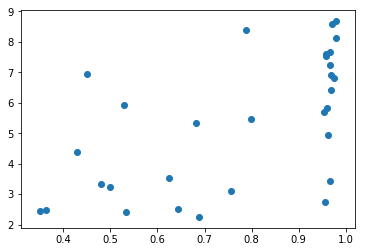

In [182]:
plt.scatter(caps_probs[full_set],full_human_set)
# plt.show()
plt.savefig('caps1.png')
print('Caps Net vs Human')
print('Spearman')
print(spearmanr(caps_probs[full_set],full_human_set))
print('Pearson')
print(pearsonr(caps_probs[full_set],full_human_set))
# for i in zip(caps_probs[full_set],full_human_set):
#     print(i)

### Dimensional Analysis for Caps Net

Dimension: 0


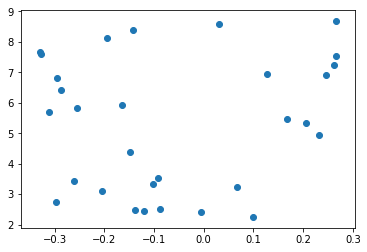

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.03759733036707453, pvalue=0.8436332422166452)
Pearson
(0.13763151680454125, 0.46828666554604603)
Dimension: 1


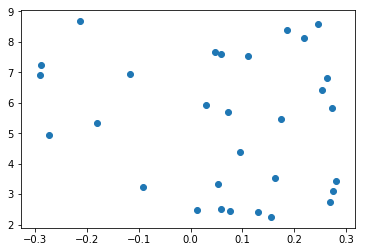

Caps Net vs Human
Spearman
SpearmanrResult(correlation=-0.12347052280311456, pvalue=0.5156699825939659)
Pearson
(-0.16637163795597446, 0.37957425589795146)
Dimension: 2


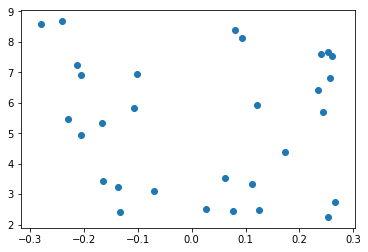

Caps Net vs Human
Spearman
SpearmanrResult(correlation=-0.1239154616240267, pvalue=0.5141463019358128)
Pearson
(-0.09129100154214899, 0.6313847720721488)
Dimension: 3


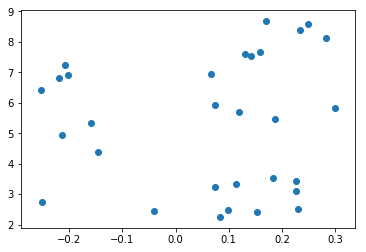

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.182202447163515, pvalue=0.3352175797909752)
Pearson
(0.0561563918990321, 0.7681892860470609)
Dimension: 4


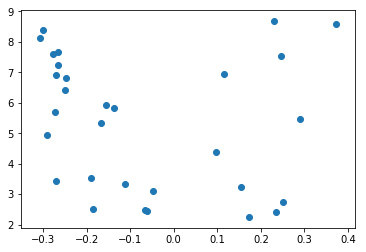

Caps Net vs Human
Spearman
SpearmanrResult(correlation=-0.2876529477196885, pvalue=0.12322467231858558)
Pearson
(-0.15850532846613632, 0.4028246258004612)
Dimension: 5


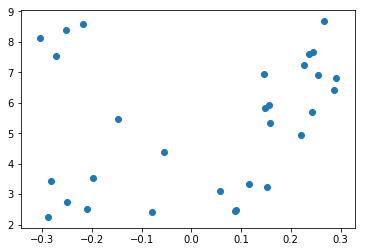

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.29076751946607343, pvalue=0.11903779361742071)
Pearson
(0.23330438289210925, 0.21469013037433357)
Dimension: 6


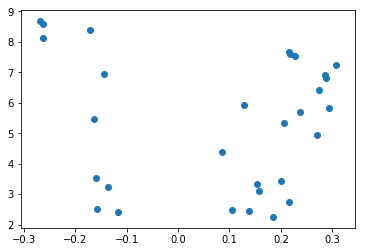

Caps Net vs Human
Spearman
SpearmanrResult(correlation=-0.02469410456062291, pvalue=0.8969402818929876)
Pearson
(-0.1118276798095452, 0.5563112177842917)
Dimension: 7


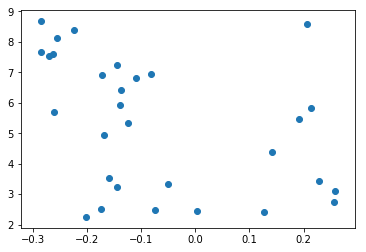

Caps Net vs Human
Spearman
SpearmanrResult(correlation=-0.4696329254727475, pvalue=0.008834512719515755)
Pearson
(-0.4051077474048324, 0.026366401012653386)
Dimension: 8


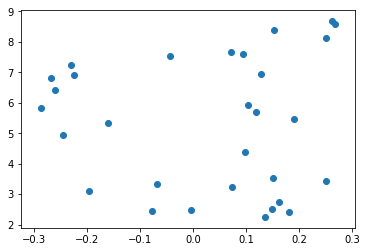

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.07230255839822024, pvalue=0.7041773195709669)
Pearson
(0.004358141815278627, 0.9817649110712152)
Dimension: 9


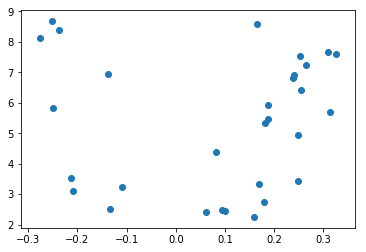

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.13993325917686317, pvalue=0.46080677886565224)
Pearson
(0.031097921832438744, 0.8704145710853232)
Dimension: 10


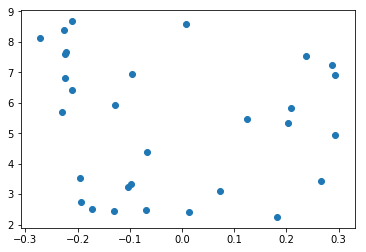

Caps Net vs Human
Spearman
SpearmanrResult(correlation=-0.260511679644049, pvalue=0.16440889004858533)
Pearson
(-0.11269559844499108, 0.55323146161447)
Dimension: 11


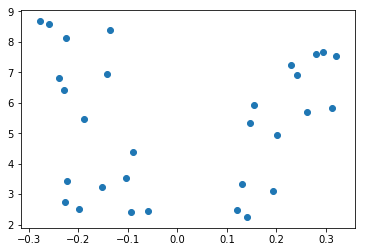

Caps Net vs Human
Spearman
SpearmanrResult(correlation=-0.009121245828698554, pvalue=0.9618460173378265)
Pearson
(0.042755120841638364, 0.8224996434288878)
Dimension: 12


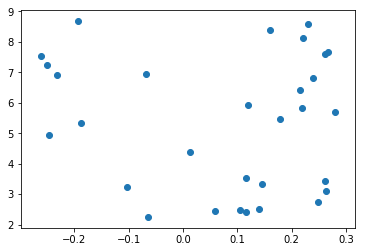

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.05228031145717464, pvalue=0.7837994469144329)
Pearson
(-0.09671251845161317, 0.6111712500612783)
Dimension: 13


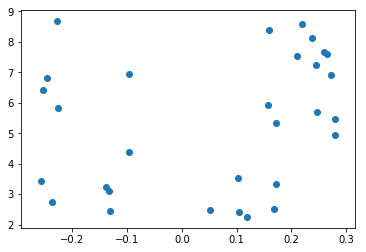

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.30589543937708563, pvalue=0.10018790084173912)
Pearson
(0.2548737420618392, 0.17406564827462287)
Dimension: 14


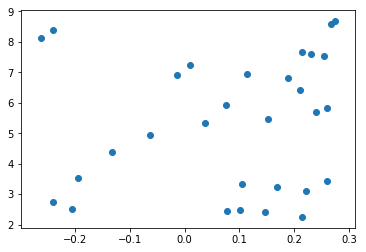

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.196440489432703, pvalue=0.2981490830329391)
Pearson
(0.13055641355965505, 0.49167068080053367)
Dimension: 15


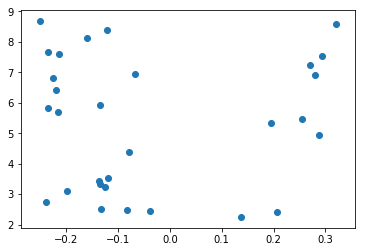

Caps Net vs Human
Spearman
SpearmanrResult(correlation=-0.0932146829810901, pvalue=0.624181677982413)
Pearson
(0.058796378759188195, 0.7576075008355742)


In [138]:
reqd_caps_final_activations = caps_final_activations[full_set]
reqd_caps_final_activations_preds = np.empty(shape=(30,16))
for i in range(30):
    reqd_caps_final_activations_preds[i] = reqd_caps_final_activations[i,int(caps_preds[full_set][i])]
for i in range(16):
    print('Dimension: {}'.format(i))
    plt.scatter(reqd_caps_final_activations_preds[:,i],full_human_set)
    plt.show()
    print('Caps Net vs Human')
    print('Spearman')
    print(spearmanr(reqd_caps_final_activations_preds[:,i],full_human_set))
    print('Pearson')
    print(pearsonr(reqd_caps_final_activations_preds[:,i],full_human_set))

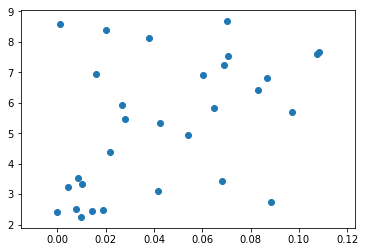

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.4442714126807564, pvalue=0.013910687533536437)
Pearson
(0.43185791770344867, 0.017169051284358496)


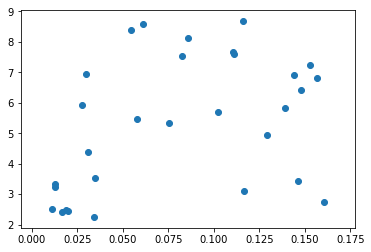

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.3971078976640712, pvalue=0.029790260179653166)
Pearson
(0.4012475341926276, 0.027976063490383552)


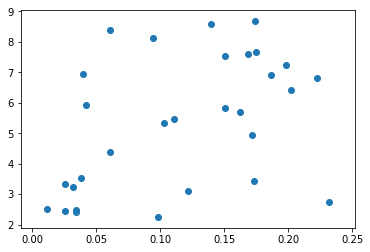

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.46651835372636263, pvalue=0.009357934968660869)
Pearson
(0.44993762114251407, 0.012604855343079329)


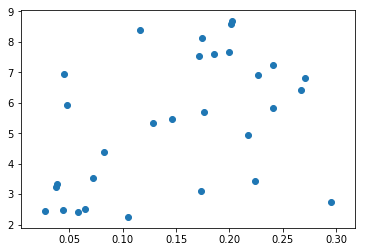

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.43893214682981085, pvalue=0.015242568393486361)
Pearson
(0.4523122067019316, 0.012088955608767432)


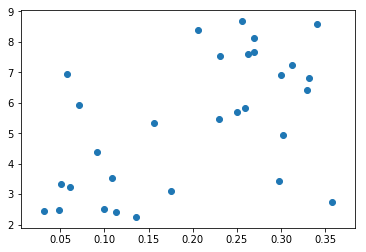

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.49187986651835364, pvalue=0.005766177408965755)
Pearson
(0.5444776164107721, 0.001866484194954005)


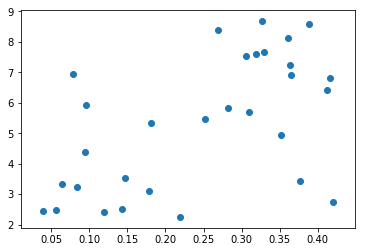

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.49988876529477194, pvalue=0.004911002394510981)
Pearson
(0.5591718731275759, 0.0013170015197298136)


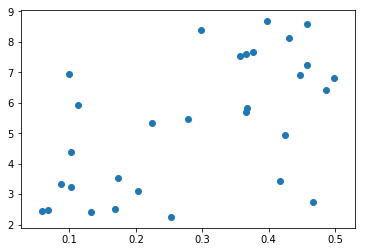

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5221357063403782, pvalue=0.0030802795912020352)
Pearson
(0.5796421372587963, 0.0007882425039422703)


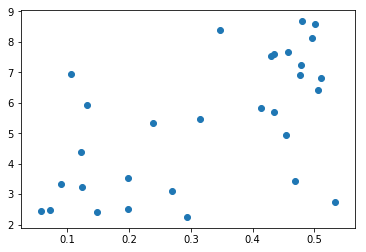

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5470522803114571, pvalue=0.001757862423003951)
Pearson
(0.5903436895868552, 0.0005945530275455713)


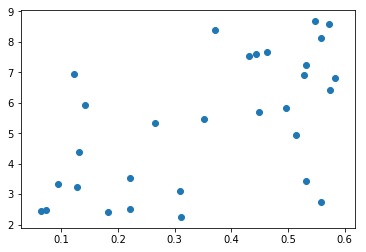

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5430478309232479, pvalue=0.0019292831845464742)
Pearson
(0.5838088744845383, 0.0007070940796246944)


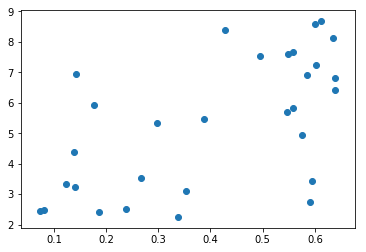

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5946607341490544, pvalue=0.0005291407010619518)
Pearson
(0.6104285087721896, 0.00034076829420300465)


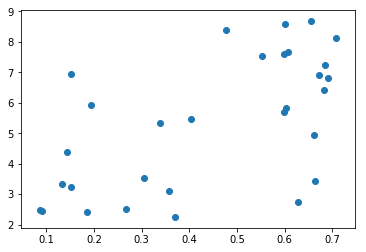

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5581757508342603, pvalue=0.0013491866915459937)
Pearson
(0.6057859395021525, 0.0003888390033324903)


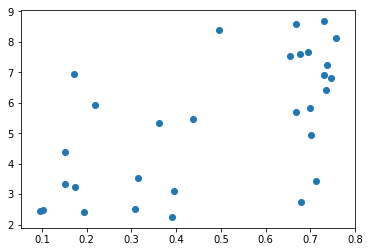

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5875417130144606, pvalue=0.0006407178314731811)
Pearson
(0.6198730031308687, 0.00025886764914536195)


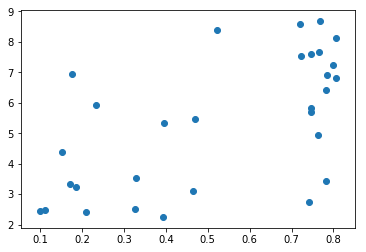

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5906562847608453, pvalue=0.0005895886587000801)
Pearson
(0.6107918165443913, 0.000337238138225411)


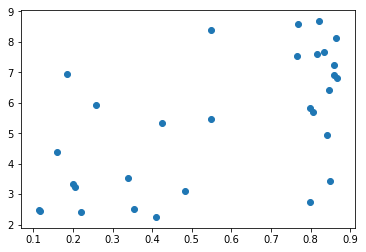

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5630700778642936, pvalue=0.0011973909518797638)
Pearson
(0.6087699565649302, 0.0003573019173631966)


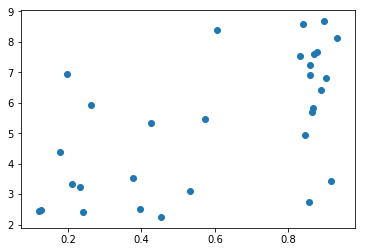

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5781979977753059, pvalue=0.0008182126424912135)
Pearson
(0.606693632752898, 0.000378995763685294)


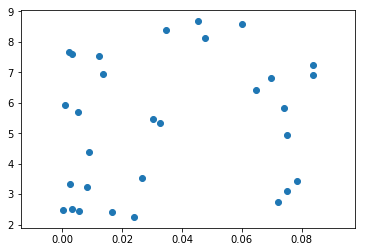

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.1870967741935484, pvalue=0.322171559226561)
Pearson
(0.20748152908666032, 0.27126211442232323)


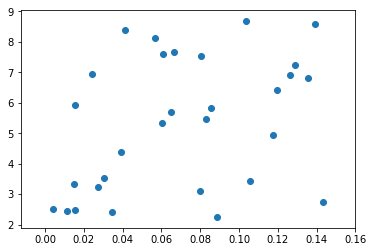

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.34638487208008895, pvalue=0.060774172271622955)
Pearson
(0.37094384912688294, 0.0435852852043862)


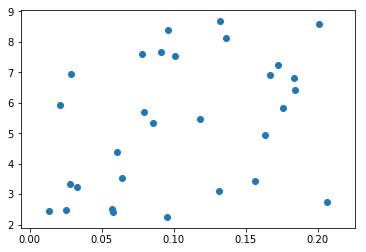

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.3975528364849833, pvalue=0.029590797228926352)
Pearson
(0.37641422938229946, 0.04034505406777846)


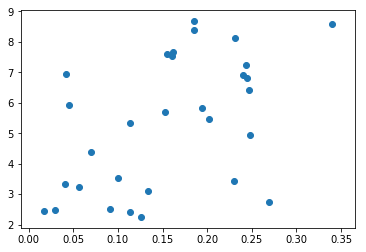

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.4758620689655172, pvalue=0.007861497272991739)
Pearson
(0.5035892876580083, 0.0045540308272297774)


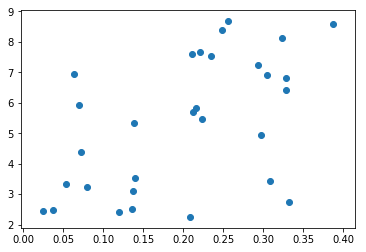

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5181312569521691, pvalue=0.003357800077645299)
Pearson
(0.5329271618277693, 0.002428548349886802)


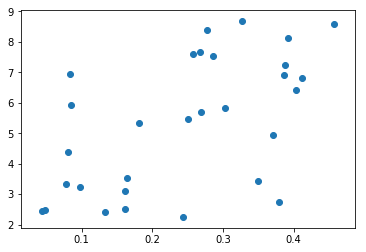

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5719688542825361, pvalue=0.0009592261667029301)
Pearson
(0.5635345263125474, 0.0011837924330846202)


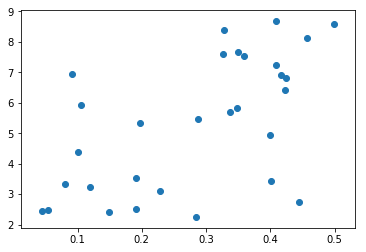

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5630700778642936, pvalue=0.0011973909518797638)
Pearson
(0.582390593173456, 0.0007338516559970254)


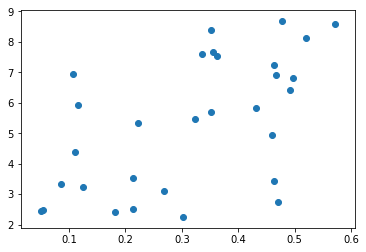

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5848720800889877, pvalue=0.0006876005693208072)
Pearson
(0.5711017423215538, 0.0009804504239240175)


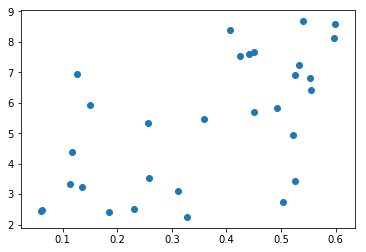

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6040044493882092, pvalue=0.00040881565948975467)
Pearson
(0.608752894554999, 0.0003574756196442632)


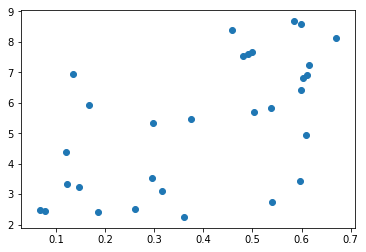

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5581757508342603, pvalue=0.0013491866915459937)
Pearson
(0.6049594586881335, 0.00039799700219598995)


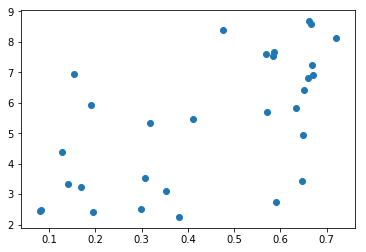

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6173526140155728, pvalue=0.00027881085825141)
Pearson
(0.6230047512626591, 0.00023585265894727743)


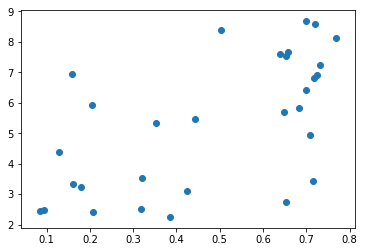

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5902113459399333, pvalue=0.0005966658393068262)
Pearson
(0.6144104375086137, 0.00030380118320907115)


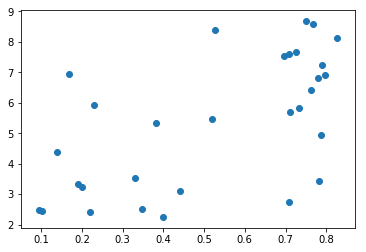

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5688542825361512, pvalue=0.0010373837232275922)
Pearson
(0.6125284842257098, 0.0003208057840061964)


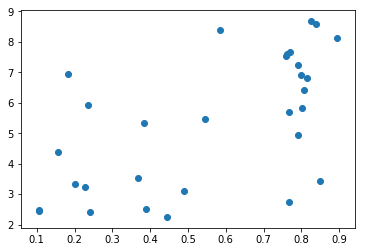

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5813125695216907, pvalue=0.0007547797838635125)
Pearson
(0.6094020480142781, 0.0003509191011464521)


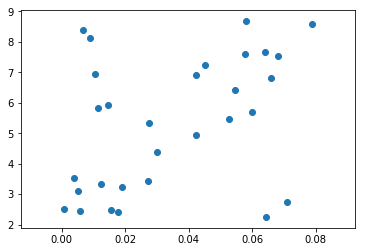

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.3125695216907675, pvalue=0.09262649946157406)
Pearson
(0.3917086472075439, 0.03229890863555236)


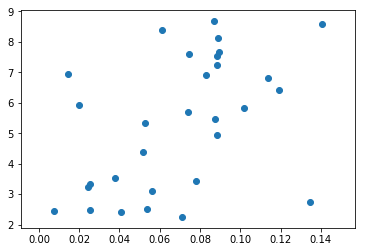

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.4901001112347052, pvalue=0.005972539175648982)
Pearson
(0.459570454339635, 0.010620351480833503)


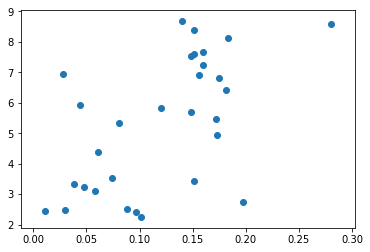

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.48609566184649605, pvalue=0.006459943079453843)
Pearson
(0.5707658975064227, 0.00098878051995264)


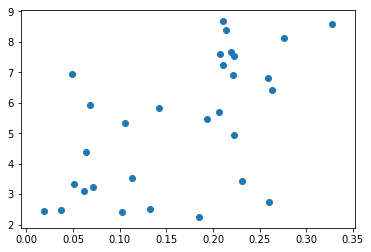

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5426028921023358, pvalue=0.0019491958526757923)
Pearson
(0.5822888042898277, 0.0007358057285512297)


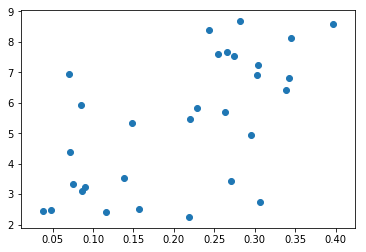

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5706340378197998, pvalue=0.0009920679647321658)
Pearson
(0.6154961217398491, 0.0002943581391881127)


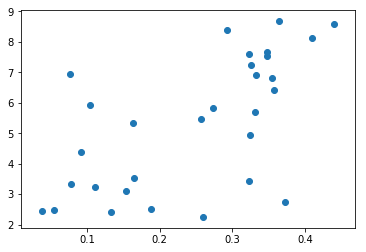

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6084538375973303, pvalue=0.0003605323408641966)
Pearson
(0.6243858923696138, 0.000226292274962399)


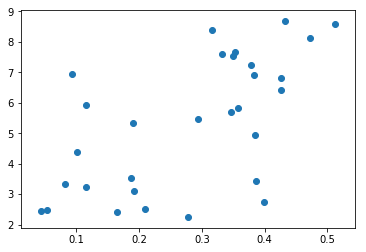

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.567964404894327, pvalue=0.0010607122456729066)
Pearson
(0.6149068901995537, 0.0002994504253846003)


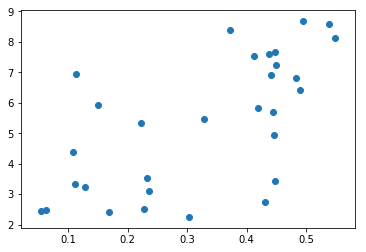

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6453837597330366, pvalue=0.0001176496221177394)
Pearson
(0.6474966457230418, 0.00010985685339549266)


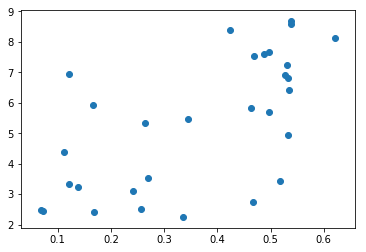

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6533926585094549, pvalue=9.048411497828581e-05)
Pearson
(0.6393251251204617, 0.00014279392309968306)


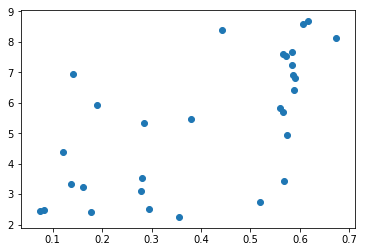

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6943270300333704, pvalue=2.0799420079671368e-05)
Pearson
(0.6528668491621494, 9.207865814628569e-05)


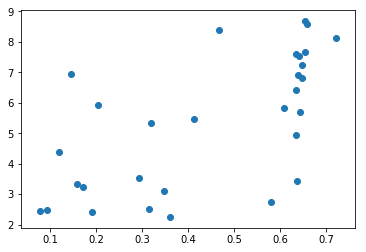

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.7005561735261402, pvalue=1.6284029560970613e-05)
Pearson
(0.6405088598771886, 0.00013753577823744166)


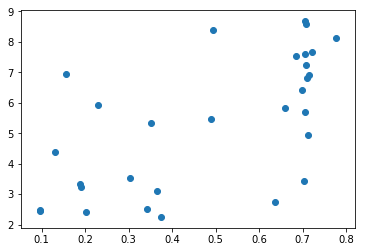

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6422691879866518, pvalue=0.00013003456866118328)
Pearson
(0.6358738970589783, 0.0001591589183927713)


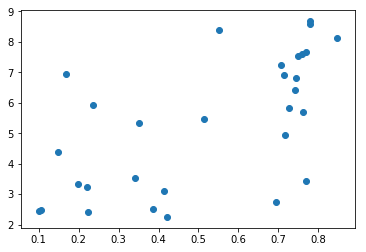

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6587319243604004, pvalue=7.563292651001827e-05)
Pearson
(0.6298878658801504, 0.00019152599911296465)


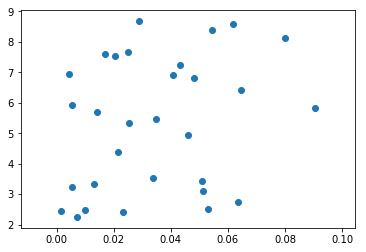

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.27519466073414905, pvalue=0.14106233520114106)
Pearson
(0.2670151044674491, 0.15375071833601042)


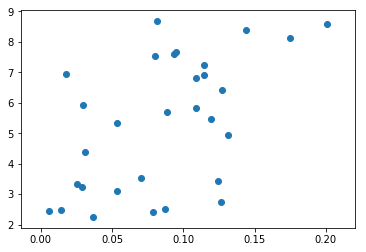

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5025583982202447, pvalue=0.004651170672352951)
Pearson
(0.5381977244678658, 0.002156158849242094)


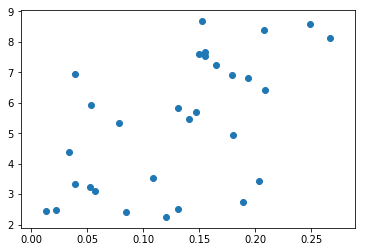

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5701890989988877, pvalue=0.0010032315284755821)
Pearson
(0.5704653364932869, 0.0009962878518298965)


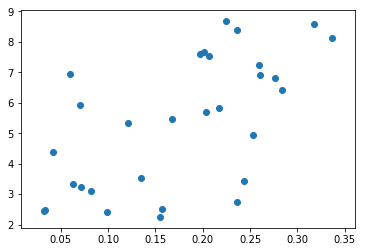

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5804226918798664, pvalue=0.0007724477313161047)
Pearson
(0.6127995961873471, 0.0003183054152919661)


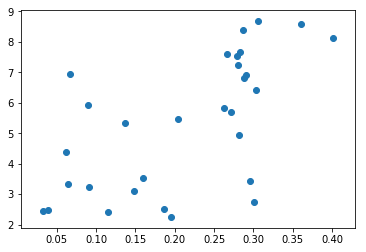

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6040044493882092, pvalue=0.00040881565948975467)
Pearson
(0.6254911124986902, 0.00021889082204336812)


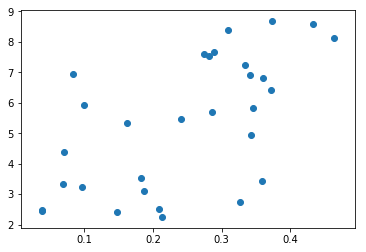

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6013348164627365, pvalue=0.0004404461261122955)
Pearson
(0.6086149524581145, 0.0003588826991542003)


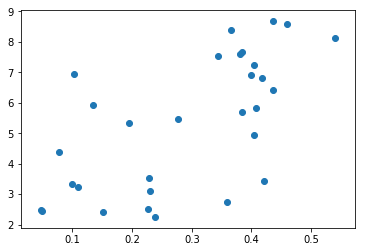

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6195773081201335, pvalue=0.00026114009329501867)
Pearson
(0.6450717018629911, 0.0001188413102259822)


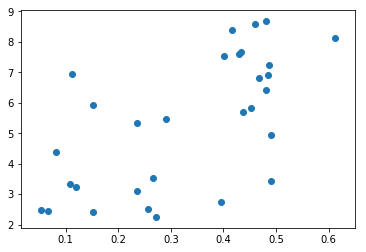

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5826473859844271, pvalue=0.0007289421342064486)
Pearson
(0.6337849850428549, 0.0001698544254059934)


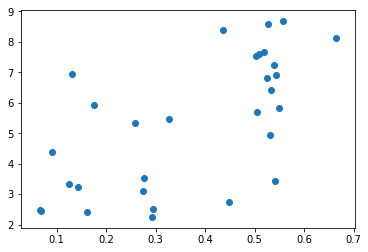

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6106785317018909, pvalue=0.0003383354124309253)
Pearson
(0.6509442478439381, 9.812443609591801e-05)


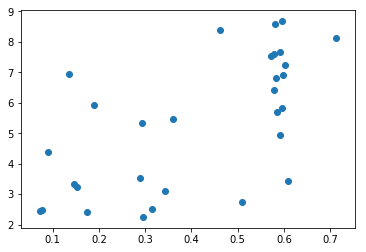

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5737486095661846, pvalue=0.0009169181563019528)
Pearson
(0.6383971766586507, 0.0001470400168898689)


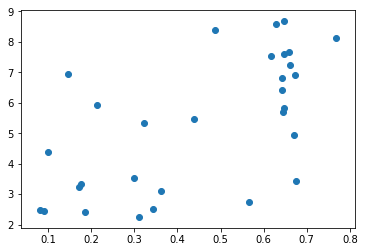

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5710789766407119, pvalue=0.0009810131454760856)
Pearson
(0.6343236922607394, 0.00016703682901984026)


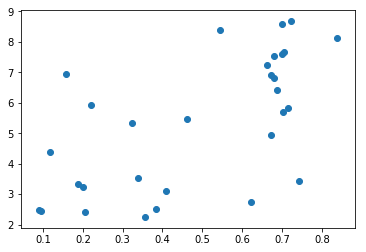

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6146829810901, pvalue=0.0003014058285718863)
Pearson
(0.6277929237576539, 0.00020416097908711325)


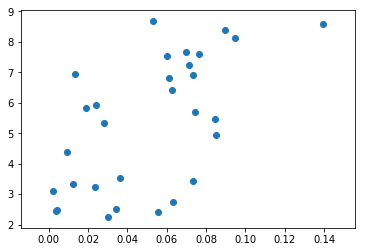

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5577308120133482, pvalue=0.0013637828214433285)
Pearson
(0.5998962357431039, 0.0004583691898365947)


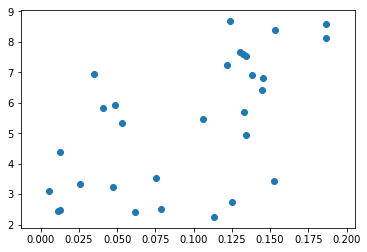

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5879866518353727, pvalue=0.0006331832932225907)
Pearson
(0.6032579050421358, 0.00041745249914608266)


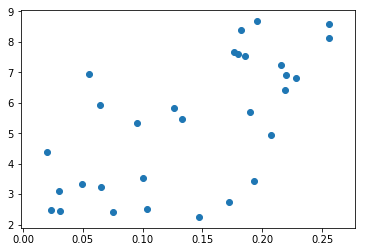

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6249165739710789, pvalue=0.00022271117689531125)
Pearson
(0.652975100598923, 9.17483478759643e-05)


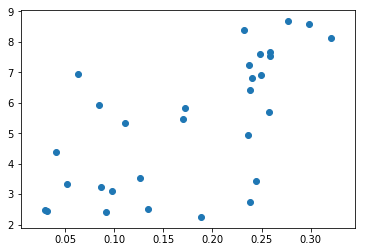

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6707452725250278, pvalue=4.9871057803906976e-05)
Pearson
(0.6581773062615687, 7.706715025091619e-05)


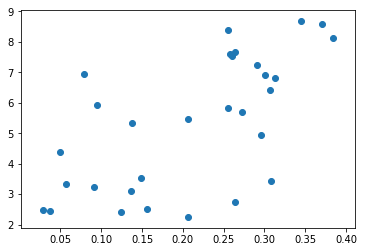

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5968854282536151, pvalue=0.0004979726681510413)
Pearson
(0.6447752917220227, 0.00011998317787628429)


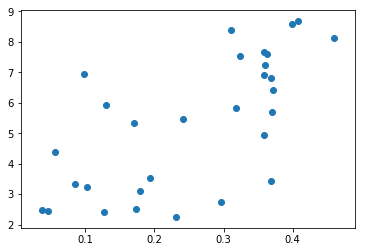

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6685205784204672, pvalue=5.3945062895507954e-05)
Pearson
(0.6744427028695129, 4.370558031668861e-05)


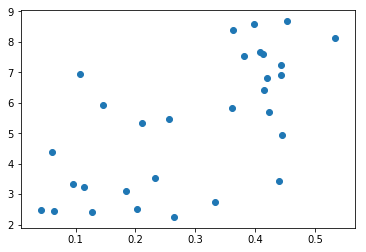

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6124582869855395, pvalue=0.0003214560097524894)
Pearson
(0.6557516061867078, 8.362925777310888e-05)


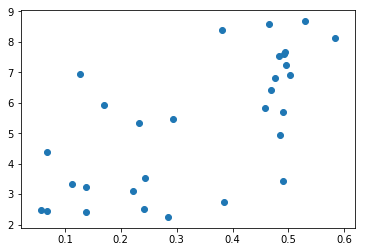

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6636262513904337, pvalue=6.397248483322399e-05)
Pearson
(0.6704993890704397, 5.030738690982701e-05)


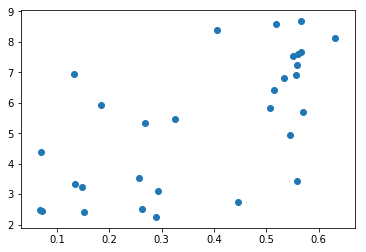

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6440489432703003, pvalue=0.00012282268638342842)
Pearson
(0.6542460312611441, 8.794856375775648e-05)


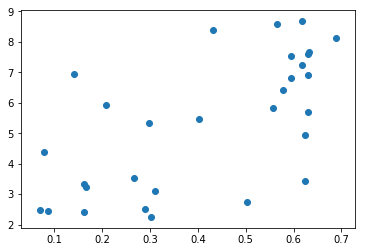

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6173526140155728, pvalue=0.00027881085825141)
Pearson
(0.6476876553964555, 0.00010917555580567545)


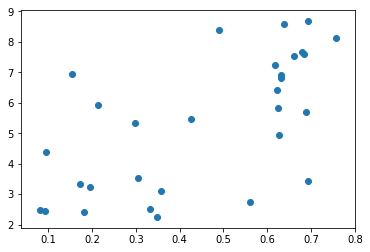

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.639154616240267, pvalue=0.00014356586246425373)
Pearson
(0.6408823452375113, 0.00013591286722017482)


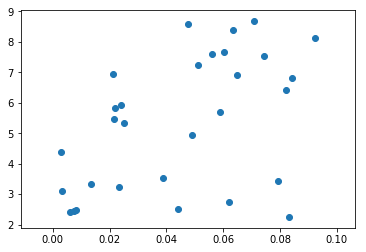

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.4629588431590656, pvalue=0.009987896327965677)
Pearson
(0.4759175569238709, 0.007853255208686342)


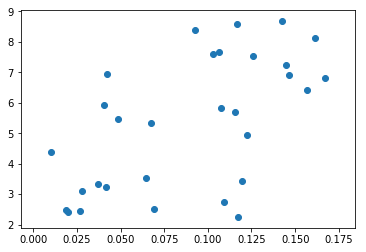

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5434927697441602, pvalue=0.0019095471435392854)
Pearson
(0.5928833296515316, 0.000555262587567463)


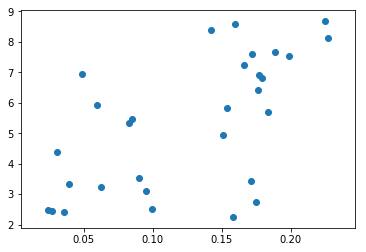

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6062291434927697, pvalue=0.00038400497510359955)
Pearson
(0.6109590404398538, 0.00033562415562504017)


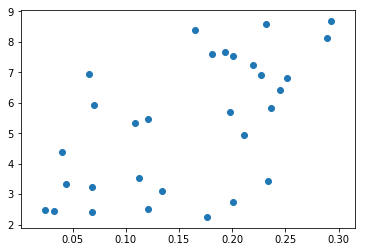

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5612903225806452, pvalue=0.0012507698247351973)
Pearson
(0.6002521741416151, 0.00045387581852463724)


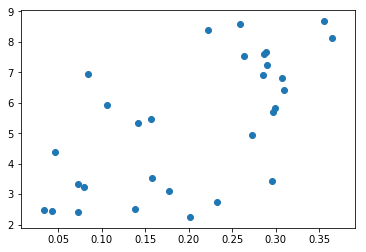

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6195773081201335, pvalue=0.00026114009329501867)
Pearson
(0.6429622444912215, 0.00012718259480544957)


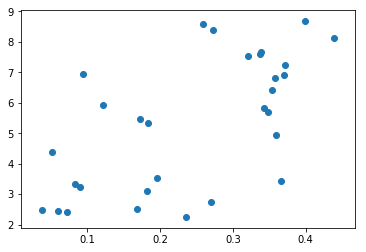

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6057842046718577, pvalue=0.0003888580301229848)
Pearson
(0.6221257859700388, 0.0002421216102759974)


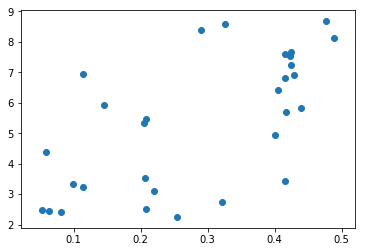

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6511679644048943, pvalue=9.740321613472422e-05)
Pearson
(0.6416492638160805, 0.0001326336437770283)


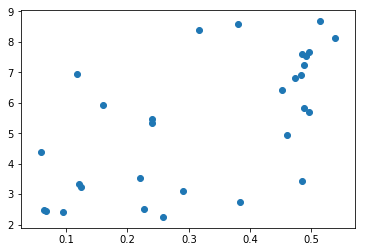

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6338153503893215, pvalue=0.00016969449076919136)
Pearson
(0.6263646084185643, 0.00021319379921132402)


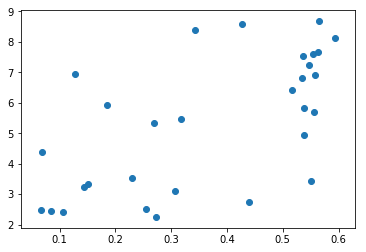

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6400444938820912, pvalue=0.00013957760813906728)
Pearson
(0.6233715542130003, 0.0002332793558934971)


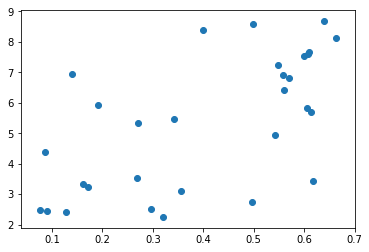

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6195773081201335, pvalue=0.00026114009329501867)
Pearson
(0.6174610645316393, 0.0002779255220469374)


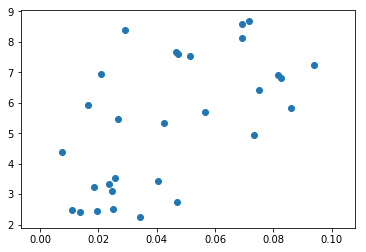

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5746384872080088, pvalue=0.0008963832217177484)
Pearson
(0.5988655092680246, 0.0004716029098390041)


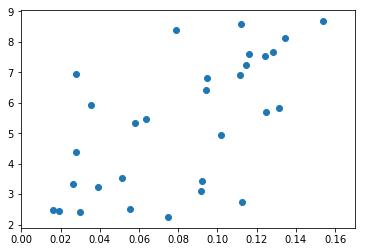

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6360400444938822, pvalue=0.0001583344842018344)
Pearson
(0.6261933845412956, 0.0002143000668279406)


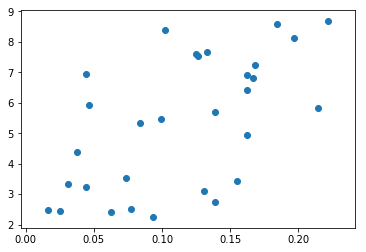

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.585761957730812, pvalue=0.0006716491464519385)
Pearson
(0.590706232421875, 0.0005887988175177566)


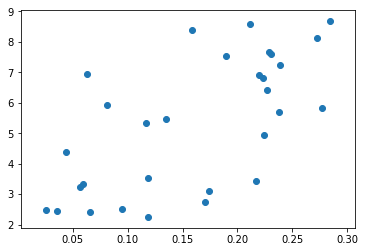

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6409343715239153, pvalue=0.00013568815316383347)
Pearson
(0.6494038564524786, 0.0001032208942209989)


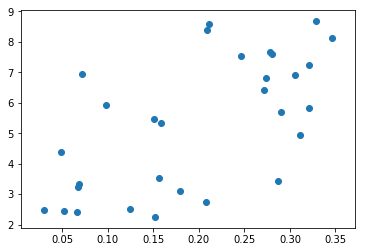

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6351501668520578, pvalue=0.00016279476455324394)
Pearson
(0.6268427489548564, 0.0002101313167337931)


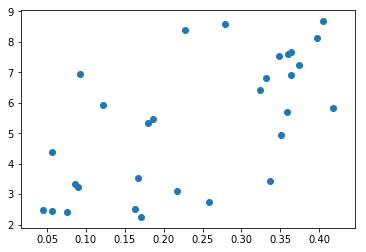

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6703003337041158, pvalue=5.066311535406339e-05)
Pearson
(0.6456822302616463, 0.0001165197839953074)


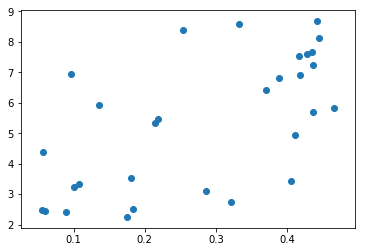

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6427141268075639, pvalue=0.00012819715611418699)
Pearson
(0.6248305012612295, 0.0002232885709466583)


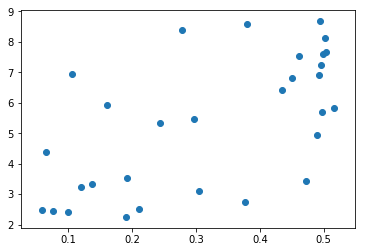

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6226918798665184, pvalue=0.00023806744077033338)
Pearson
(0.6209384226490693, 0.0002508242480824719)


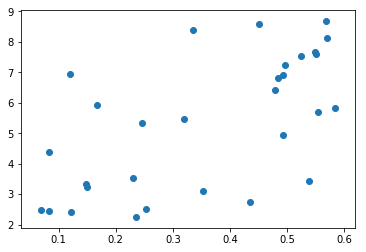

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6106785317018909, pvalue=0.0003383354124309253)
Pearson
(0.6160439224699141, 0.0002896927456801354)


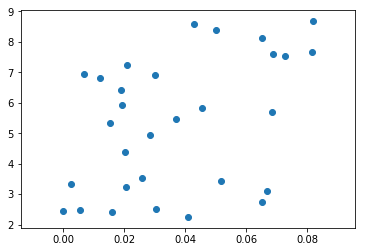

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.4264738598442714, pvalue=0.01876687593327937)
Pearson
(0.40760885804054375, 0.025364434246186576)


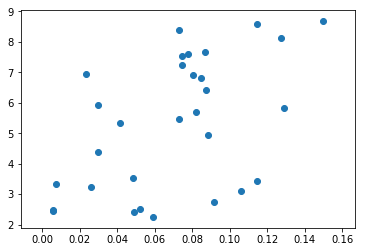

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.4589543937708565, pvalue=0.010738880925773105)
Pearson
(0.5131910694020323, 0.003729570171270966)


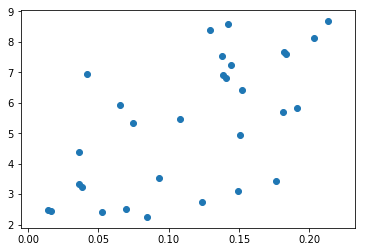

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6080088987764182, pvalue=0.00036512285107145767)
Pearson
(0.621547512083344, 0.00024632601579478334)


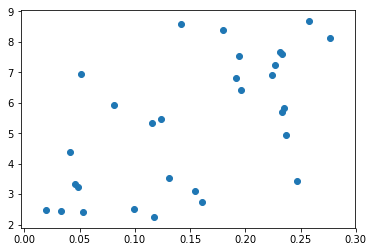

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5826473859844271, pvalue=0.0007289421342064486)
Pearson
(0.6052588749275881, 0.0003946575161416512)


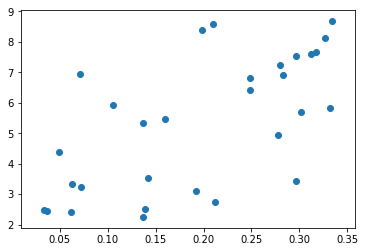

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6493882091212457, pvalue=0.00010327385149011718)
Pearson
(0.6332781858842604, 0.00017254357099068157)


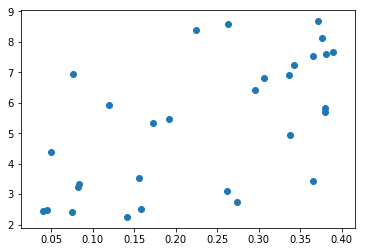

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6244716351501668, pvalue=0.00022571024030511785)
Pearson
(0.6092211211424768, 0.0003527357224214688)


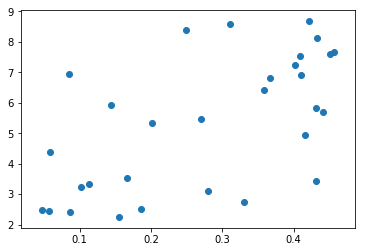

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5839822024471636, pvalue=0.0007038834740885719)
Pearson
(0.6074503341895183, 0.00037095864066960657)


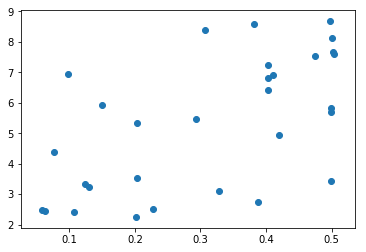

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5888765294771968, pvalue=0.0006183473089266397)
Pearson
(0.6001093259441743, 0.0004556744528009672)


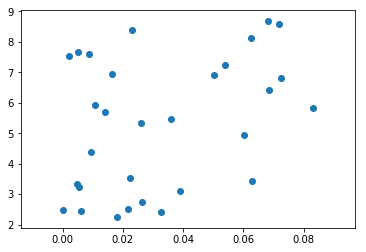

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.28720800889877635, pvalue=0.1238315568442359)
Pearson
(0.3635505656047731, 0.04829089182030346)


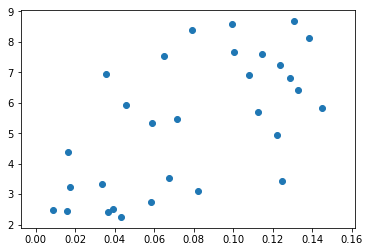

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6053392658509456, pvalue=0.00039376510970386206)
Pearson
(0.6250118993626368, 0.00022207325816487472)


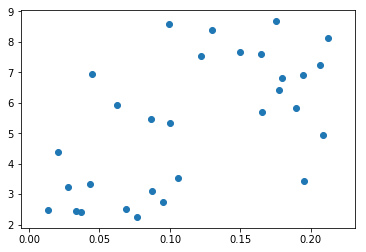

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5710789766407119, pvalue=0.0009810131454760856)
Pearson
(0.5883876074786097, 0.000626460332188653)


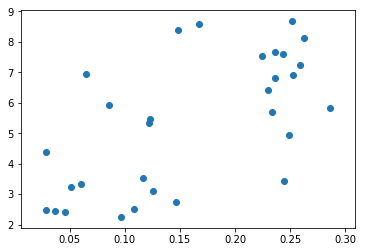

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6338153503893215, pvalue=0.00016969449076919136)
Pearson
(0.637661227703124, 0.00015048695821307515)


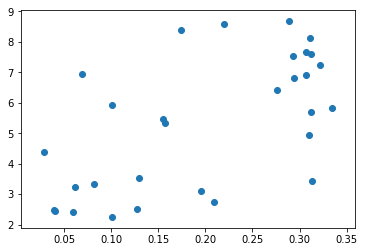

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5568409343715239, pvalue=0.0013933881771764085)
Pearson
(0.6113005374541454, 0.0003323493314212998)


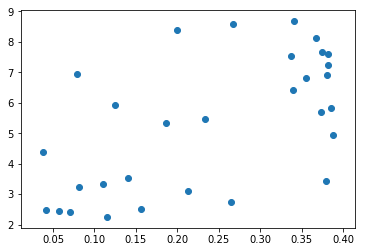

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.546607341490545, pvalue=0.0017762317844310926)
Pearson
(0.6059772148142726, 0.0003867462173475015)


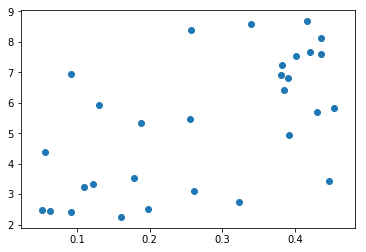

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5635150166852058, pvalue=0.0011843609298824163)
Pearson
(0.6052320028470133, 0.0003949562162550087)


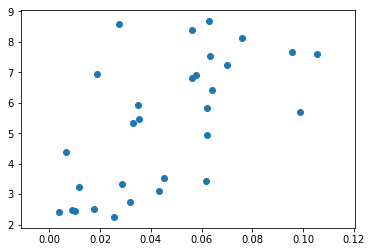

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6569521690767519, pvalue=8.032165733617396e-05)
Pearson
(0.6252544353313744, 0.0002204574987383154)


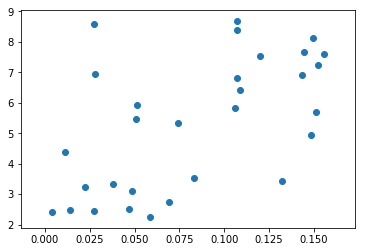

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5697441601779756, pvalue=0.0010145047374310254)
Pearson
(0.5669573875866171, 0.0010876631727959635)


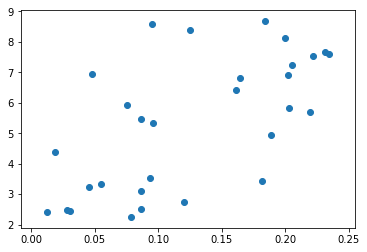

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.649833147942158, pvalue=0.00010177739046409313)
Pearson
(0.6299501653428754, 0.00019116112506080125)


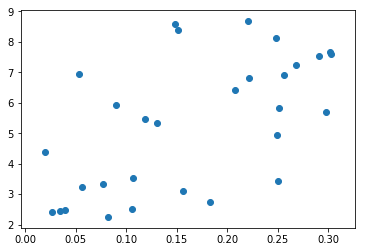

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5888765294771968, pvalue=0.0006183473089266397)
Pearson
(0.5986529984892143, 0.00047437284085075716)


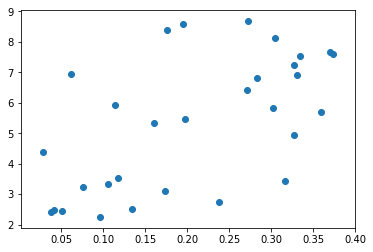

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6008898776418242, pvalue=0.0004459224056212736)
Pearson
(0.5968501830892835, 0.0004984535691088474)


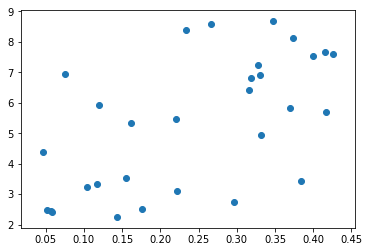

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5955506117908788, pvalue=0.0005164733866336921)
Pearson
(0.5981558305782873, 0.00048090911729548714)


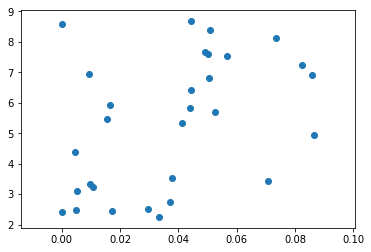

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.450055617352614, pvalue=0.012578791952999643)
Pearson
(0.42317491197695106, 0.01980523594047916)


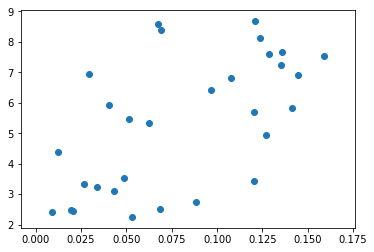

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6066740823136819, pvalue=0.00037920543422414766)
Pearson
(0.5959204637236423, 0.0005112875879486904)


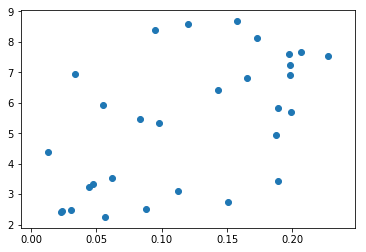

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5675194660734149, pvalue=0.001072547397715183)
Pearson
(0.564638783991154, 0.0011520007179215992)


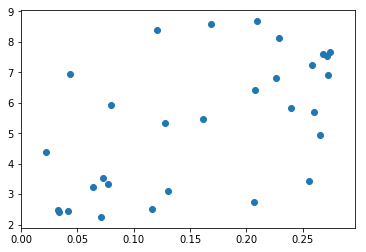

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5853170189098998, pvalue=0.0006795837838299531)
Pearson
(0.5682012600281248, 0.0010544586680437877)


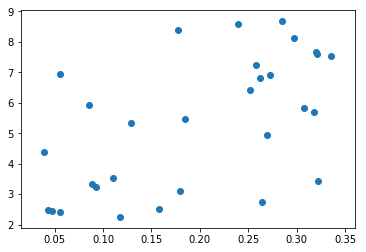

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.539043381535039, pvalue=0.00211501472851774)
Pearson
(0.5723793133239634, 0.0009493202711922611)


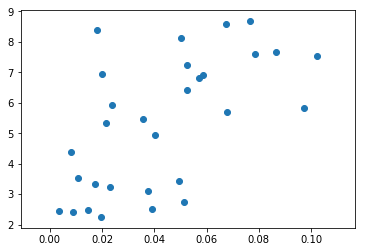

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.628921023359288, pvalue=0.00019726831516437448)
Pearson
(0.601942153262974, 0.00043306675036139315)


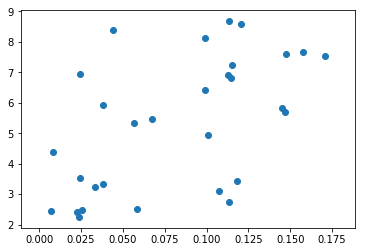

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5853170189098998, pvalue=0.0006795837838299531)
Pearson
(0.5532612931739255, 0.0015182065344633718)


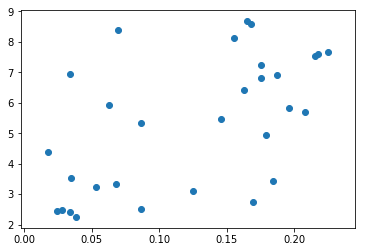

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5328142380422692, pvalue=0.002434695615550987)
Pearson
(0.5665275443994421, 0.001099347998672795)


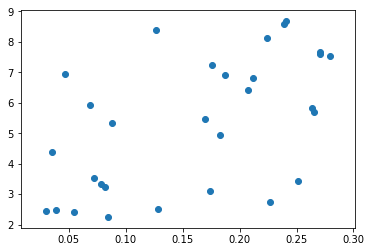

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5563959955506118, pvalue=0.0014083995715833929)
Pearson
(0.5588598268696512, 0.0013270111387880129)


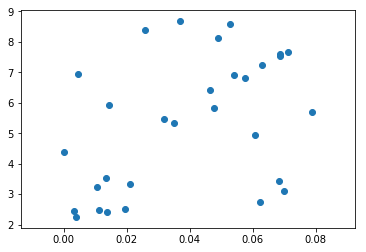

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.432258064516129, pvalue=0.017054947032249808)
Pearson
(0.43580499335110773, 0.016070731366604897)


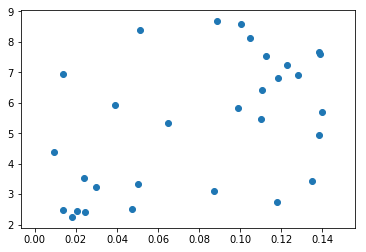

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.46785317018909905, pvalue=0.009130497522664139)
Pearson
(0.4991740494133808, 0.0049826330734440765)


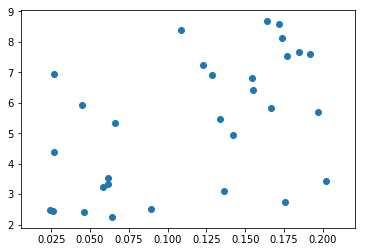

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.4816462736373748, pvalue=0.007040743842946091)
Pearson
(0.5131471320937743, 0.003733028995726594)


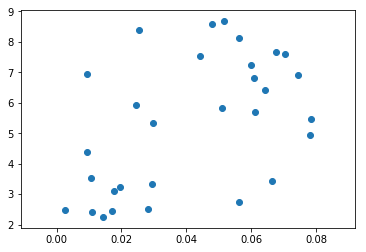

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.4473859844271412, pvalue=0.01317961550566672)
Pearson
(0.5069426993025403, 0.004249952363090141)


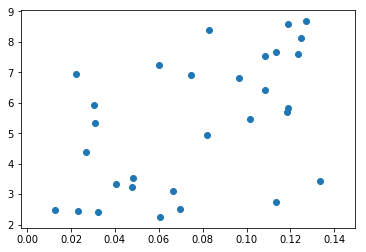

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.5194660734149055, pvalue=0.0032629966132636163)
Pearson
(0.5140926079953716, 0.003659204335270704)


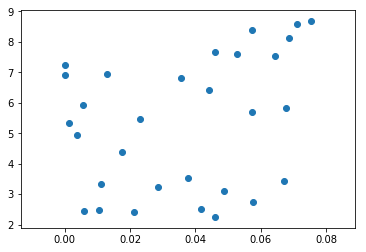

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.3290322580645161, pvalue=0.0758291273097093)
Pearson
(0.3067588132794753, 0.09918437559926405)
0.6744427028695129 (4, 10)


In [173]:
maxie = 0
best = (0,0)
for i in range(16):
    for j in range(i+1,16):
        temp = np.sum(np.square(reqd_caps_final_activations_preds[:,i:j]),axis=-1,keepdims=False)
        plt.scatter(temp,full_human_set)
        plt.show()
        print('Caps Net vs Human')
        print('Spearman')
        print(spearmanr(temp,full_human_set))
        print('Pearson')
        print(pearsonr(temp,full_human_set))
        if pearsonr(temp,full_human_set)[0] > maxie:
            maxie=pearsonr(temp,full_human_set)[0]
            best=(i,j)
print(maxie,best)

Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6685205784204672, pvalue=5.3945062895507954e-05)
Pearson
(0.6744427028695129, 4.370558031668861e-05)


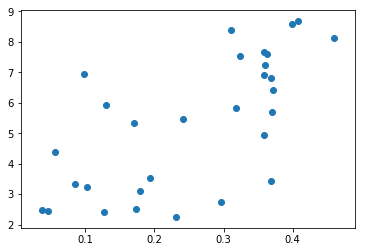

In [183]:
temp = np.sum(np.square(reqd_caps_final_activations_preds[:,4:10]),axis=-1,keepdims=False)
plt.scatter(temp,full_human_set)
# plt.show()
plt.savefig('caps2.png')

print('Caps Net vs Human')
print('Spearman')
print(spearmanr(temp,full_human_set))
print('Pearson')
print(pearsonr(temp,full_human_set))

## Caps Net vs Human - Bad Examples

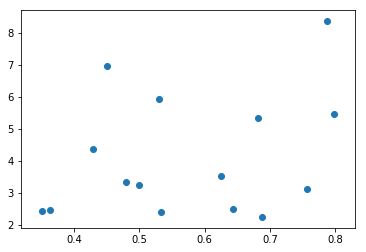

SpearmanrResult(correlation=0.2071428571428571, pvalue=0.4588428049634703)
(0.3214385377453736, 0.24270360812054928)


In [139]:
x = []
y = []
for i in range(len(full_set)):
    if caps_probs[full_set][i] <= 0.8:
        x.append(caps_probs[full_set][i])
        y.append(full_human_set[i])
plt.scatter(x,y)
plt.show()
print(spearmanr(x,y))
print(pearsonr(x,y))
# for i in zip(x,y):
#     print(i)

## Conv Net vs Human - Probabilities

SpearmanrResult(correlation=0.6133448423348075, pvalue=0.00031332888897060956)
(0.1412560625898952, 0.4565368650696813)


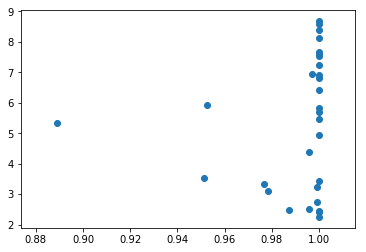

In [184]:
plt.scatter(conv_probs[full_set],full_human_set)
# plt.show()
plt.savefig('conv1.png')

print(spearmanr(conv_probs[full_set],full_human_set))
print(pearsonr(conv_probs[full_set],full_human_set))
# for i in zip(conv_probs[full_set],full_human_set):
#     print(i)

## Conv Net vs Human - Scores

SpearmanrResult(correlation=0.6106785317018909, pvalue=0.0003383354124309253)
(0.6862163733613436, 2.8352352362642938e-05)


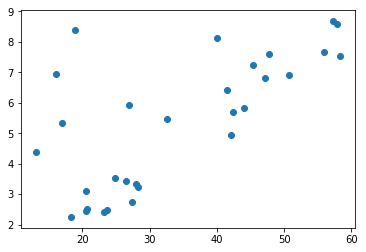

In [185]:
plt.scatter(conv_scores[full_set],full_human_set)
# plt.show()
plt.savefig('conv2.png')

print(spearmanr(conv_scores[full_set],full_human_set))
print(pearsonr(conv_scores[full_set],full_human_set))
# for i in zip(conv_probs[full_set],full_human_set):
#     print(i)

## Conv Net vs Human - Bad examples

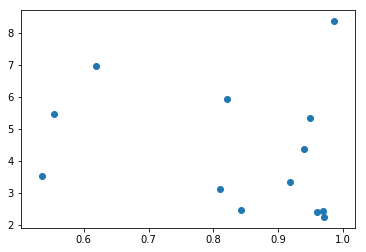

SpearmanrResult(correlation=-0.2967032967032967, pvalue=0.3249215884859752)


In [68]:
x = []
y = []
for i in range(len(full_set)):
    if conv_probs[full_set][i] <= 0.99:
        x.append(conv_probs[full_set][i])
        y.append(full_human_set[i])
plt.scatter(x,y)
plt.show()
print(spearmanr(x,y))
# for i in zip(x,y):
#     print(i)

## SVM vs Human

SpearmanrResult(correlation=0.5768631813125694, pvalue=0.0008467969337743622)
(0.5939716571508262, 0.0005391366003147072)


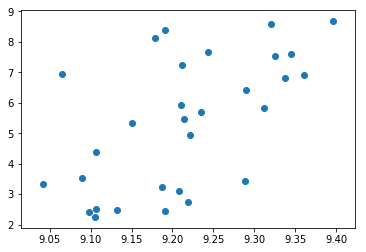

In [181]:
plt.scatter(svm_conf[full_set],full_human_set)
# plt.show()
plt.savefig('svm1.png')

print(spearmanr(svm_conf[full_set],full_human_set))
print(pearsonr(svm_conf[full_set],full_human_set))
# for i in zip(svm_conf[full_set],full_human_set):
#     print(i)

## SVM vs Human - Outlier

In [75]:
# x = []
# y = []
# for i in range(len(full_set)):
#     if svm_conf[full_set][i] > 8.5:
#         x.append(svm_conf[full_set][i])
#         y.append(full_human_set[i])
# plt.scatter(x,y)
# plt.show()
# print(spearmanr(x,y))
# # for i in zip(x,y):
# #     print(i)

## SVM Prob vs Human

SpearmanrResult(correlation=0.5586206896551724, pvalue=0.001334726825542171)
(0.43763294680143555, 0.015582217588270454)


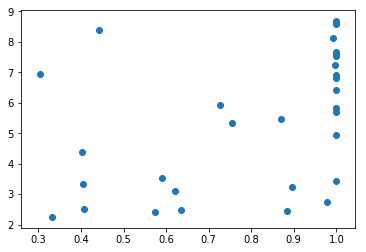

In [186]:
plt.scatter(svm_probs[full_set],full_human_set)
# plt.show()
plt.savefig('svm2.png')

print(spearmanr(svm_probs[full_set],full_human_set))
print(pearsonr(svm_probs[full_set],full_human_set))
# for i in zip(svm_probs[full_set],full_human_set):
#     print(i)

In [101]:
print('Caps Net vs Human')
print('Spearman')
print(spearmanr(caps_probs[full_set],full_human_set))
print('Pearson')
print(pearsonr(caps_probs[full_set],full_human_set))
print('--------------------------')
print('Conv Net vs Human Prob')
print('Spearman')
print(spearmanr(conv_probs[full_set],full_human_set))
print('Pearson')
print(pearsonr(conv_probs[full_set],full_human_set))
print('--------------------------')
print('Conv Net vs Human Scores')
print('Spearman')
print(spearmanr(conv_scores[full_set],full_human_set))
print('Pearson')
print(pearsonr(conv_scores[full_set],full_human_set))

print('--------------------------')
print('SVM vs Human - Prob')
print('Spearman')
print(spearmanr(svm_probs[full_set],full_human_set))
print('Pearson')
print(pearsonr(svm_probs[full_set],full_human_set))

print('--------------------------')
print('SVM vs Human - Score')
print('Spearman')
print(spearmanr(svm_conf[full_set],full_human_set))
print('Pearson')
print(pearsonr(svm_conf[full_set],full_human_set))



Caps Net vs Human
Spearman
SpearmanrResult(correlation=0.6458286985539488, pvalue=0.00011596887962139112)
Pearson
(0.6003270672171638, 0.00045293532421286945)
--------------------------
Conv Net vs Human Prob
Spearman
SpearmanrResult(correlation=0.6133448423348075, pvalue=0.00031332888897060956)
Pearson
(0.1412560625898952, 0.4565368650696813)
--------------------------
Conv Net vs Human Scores
Spearman
SpearmanrResult(correlation=0.6106785317018909, pvalue=0.0003383354124309253)
Pearson
(0.6862163733613436, 2.8352352362642938e-05)
--------------------------
SVM vs Human - Prob
Spearman
SpearmanrResult(correlation=0.5586206896551724, pvalue=0.001334726825542171)
Pearson
(0.43763294680143555, 0.015582217588270454)
--------------------------
SVM vs Human - Score
Spearman
SpearmanrResult(correlation=0.5768631813125694, pvalue=0.0008467969337743622)
Pearson
(0.5939716571508262, 0.0005391366003147072)
